## Notebook Summary
---
The contents of this notebook includes: the metric selection, individual modelings,train and test brier scores, precision scores, confusion matrix, and conclusions. 

In [171]:
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import brier_score_loss, make_scorer, confusion_matrix, plot_confusion_matrix,precision_score

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

from xgboost import XGBClassifier

from tensorflow.keras.metrics import FalsePositives
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision

### Import
All data besides PUMA and ID are scaled. Remove ID for modeling

In [235]:
X_train = pd.read_csv('cleaned_data/X_train_final.csv',index_col = 'Unnamed: 0')
X_test = pd.read_csv('cleaned_data/X_test_final.csv',index_col = 'Unnamed: 0')
X_train = X_train.drop(columns = 'id')
X_test = X_test.drop(columns = 'id')


y_train = pd.read_csv('cleaned_data/y_train.csv',index_col = 'Unnamed: 0')
y_test = pd.read_csv('cleaned_data/y_test.csv',index_col = 'Unnamed: 0')
y_train = y_train['recidivism_within_3years']
y_test = y_test['recidivism_within_3years']

# Modeling
For the challenge, Brier Score was used as the metric to optimize our models. Brier score calculates the squared mean of predicted probability minus the binary classification. A lower score results in a better predictive model. A secondary metric looked at was precision in order to minimize false positives. However, the brier score was prioritized due to limited scoring capabilities. 

In [251]:
brier_score = make_scorer(brier_score_loss,greater_is_better=False,needs_proba=True)

### Baseline

Global: .25

### Logistic Regression
To start, a logistic regression was used for a simple model and BayesSearchCV. Through the gridsearch, there was improvement with L1 penalty and a low C value of 0.0677 for feature reduction.

In [257]:
lr = LogisticRegression(max_iter = 10000)
bayes = BayesSearchCV(lr,scoring=brier_score,
                      search_spaces = {'penalty': Categorical(['l1']),
                                        'solver': Categorical(['saga']),
                                        "C": Real(1e-6, 10, prior='log-uniform')},   
                     cv= 5,
                     n_jobs = -1)
#bayes.fit(X_train,y_train)   

Pickle Model and Dataframe of Coefficients 

In [242]:
#pickle.dump(bayes,open('pickles/lr_bayes.pkl', 'wb'))
bayes = pickle.load(open('pickles/lr_bayes.pkl', 'rb'))

#pickle.dump(lr_coef_df,open('pickles/lr_coef_df.pkl', 'wb'))
lr_coef_df = pickle.load(open('pickles/lr_coef_df.pkl', 'rb'))

Show brier scores and precision between train and testing.

0.18846905845717593
0.19227260837316207
#############################
0.7286776212832551
0.7264553832321871


/Users/franknovak/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


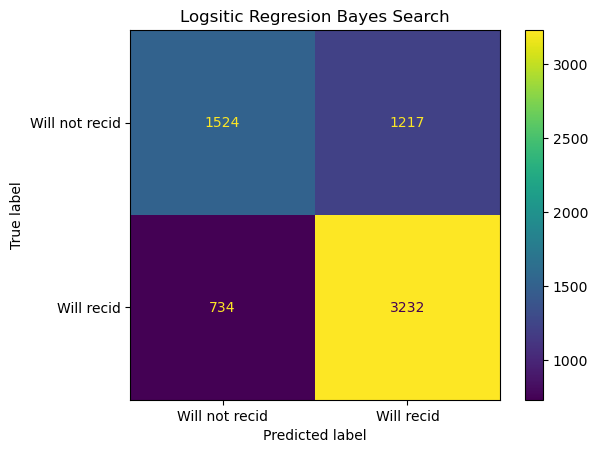

In [243]:
print(-bayes.score(X_train,y_train))
print(-bayes.score(X_test,y=y_test))
print("#############################")
plot_confusion_matrix(bayes,X_test,y_test,display_labels=["Will not recid",'Will recid'])
plt.title("Logistic Regression Bayes Search")
print(precision_score(y_train,bayes.predict(X_train)))
print(precision_score(y_test,bayes.predict(X_test)))

In [244]:
lr_coef_df = pd.DataFrame(data=bayes.best_estimator_.coef_.reshape(-1,1),columns = ['coef'],index = X_train.columns).sort_values(by='coef',ascending=False)
lr_coef_df['odd_ratio'] = lr_coef_df['coef'].apply(math.exp)
lr_coef_df.head(10)

,coef,odd_ratio
gang_affiliated,0.278006,1.320494
prior_arrest_episodes_felony,0.242007,1.273803
age_at_release_23-27,0.235596,1.265662
age_at_release_18-22,0.230575,1.259324
gender,0.160013,1.173527
prior_arrest_episodes_ppviolationcharges,0.157116,1.170132
condition_mh_sa,0.144291,1.155220
prior_arrest_episodes_property,0.141249,1.151712
prior_arrest_episodes_misd,0.138697,1.148776
supervision_risk_score_first,0.126380,1.134714


In [ ]:
r = permutation_importance(bayes,X_test,y_test,scoring='precision')

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_test.columns[i]:<8}"
                  f"{r.importances_mean[i]:.5f}"
                  f" +/- {r.importances_std[i]:.3f}")


To further extend the positivity of feature reduction, a second degree polynomial transformer and PCA(300) to see if there was any benefit to the model. Overall, the model performed worse with the additional features. 

#### Random Forest Classifier 
BayesSearch over Random Forest Classifier 

In [35]:
rf = RandomForestClassifier(n_estimators=600, max_depth=3,min_samples_split=4,
                                       min_samples_leaf=4)
bayes_rf = BayesSearchCV(rf,scoring=brier_score,
                      search_spaces = {'max_features':Integer(30,50)
                        },
                     cv= 3,
                     n_jobs = -1)
#bayes_rf.fit(X_train,y_train)

Pickle Model and Dataframe of Coefficients

In [245]:
#pickle.dump(bayes_rf,open('pickles/rf_bayes.pkl', 'wb'))
bayes_rf = pickle.load(open('pickles/rf_bayes.pkl', 'rb'))

Show brier scores and precision between train and testing.

OrderedDict([('max_features', 49)])
0.20451426683803325
0.2049378276762102
#############################


/Users/franknovak/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.6943614806769843
0.6988660226795465


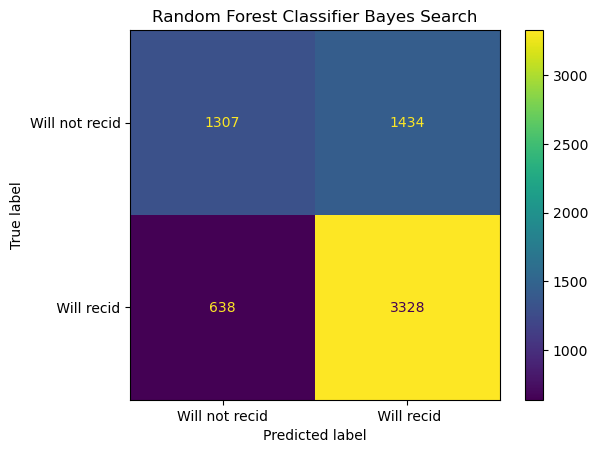

In [246]:
print(bayes_rf.best_params_)
print(-bayes_rf.score(X_train,y_train))
print(-bayes_rf.score(X_test,y_test))
print("#############################")
plot_confusion_matrix(bayes_rf,X_test,y_test,display_labels=["Will not recid",' Will recid'])
plt.title("Random Forest Classifier Bayes Search")
print(precision_score(y_train,bayes_rf.predict(X_train)))
print(precision_score(y_test,bayes_rf.predict(X_test)))

In [247]:
rf_coef_df = pd.DataFrame(data=bayes_rf.best_estimator_.feature_importances_.reshape(-1,1),
                          columns = ['feature_importance'],
                          index = bayes_rf.best_estimator_.feature_names_in_).sort_values(by='feature_importance',ascending=False)

rf_coef_df.head(10)

,feature_importance
percent_days_employed,0.448646
prior_arrest_episodes_ppviolationcharges,0.211622
gang_affiliated,0.106488
supervision_risk_score_first,0.064569
prior_arrest_episodes_felony,0.064504
age_at_release_48 or older,0.044195
prior_conviction_episodes_misd,0.013339
prior_arrest_episodes_misd,0.012134
prior_arrest_episodes_property,0.010263
avg_days_per_drugtest,0.008238


Show Permutation Importances

In [ ]:
r = permutation_importance(bayes_rf,X_test,y_test,scoring='precision')

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_test.columns[i]:<8}"
                  f"{r.importances_mean[i]:.5f}"
                  f" +/- {r.importances_std[i]:.3f}")

### XGBoost
BayesSearch overXGBoost Model

In [ ]:
xgb = XGBClassifier(n_estimators = 187,max_depth=2,min_child_weight=2,gamma = 0.7,max_leaves = 2)
bayes_xgb = BayesSearchCV(xgb,scoring=brier_score,
                      search_spaces = {'learning_rate':Real(.05,.2)},
                    cv= 3,
                    n_jobs = -1,
                    verbose=True)
#bayes_xgb.fit(X_train,y_train)

Pickle Model and Dataframe of Coefficients

In [141]:
#pickle.dump(bayes_xgb,open('pickles/xgb_bayes.pkl', 'wb'))
bayes_xgb = pickle.load(open('pickles/xgb_bayes.pkl', 'rb'))

Show brier scores and precision between train and testing.

OrderedDict([('learning_rate', 0.1935013750351709)])
0.17203865401202323
0.182188910271718
#############################


/Users/franknovak/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.7542709574890742
0.7453416149068323


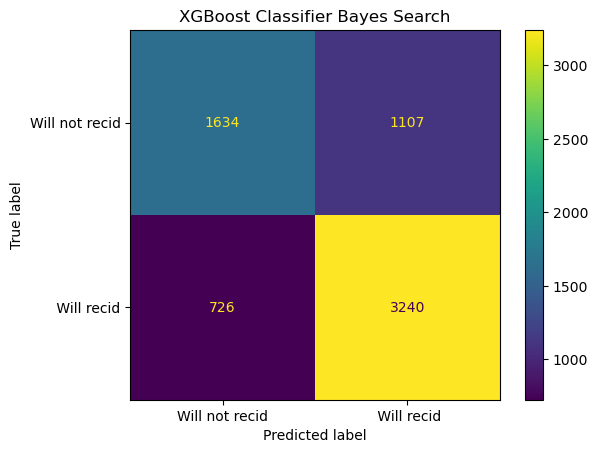

In [240]:
print(bayes_xgb.best_params_)
print(-bayes_xgb.score(X_train,y_train))
print(-bayes_xgb.score(X_test,y_test))
print("#############################")
plot_confusion_matrix(bayes_xgb,X_test,y_test,display_labels=["Will not recid",' Will recid'])
plt.title("XGBoost Classifier Bayes Search")
print(precision_score(y_train,bayes_xgb.predict(X_train)))
print(precision_score(y_test,bayes_xgb.predict(X_test)))

Savee feature importances to a DataFrame.

In [91]:
xbg_coef_df = pd.DataFrame(data=bayes_xgb.best_estimator_.feature_importances_.reshape(-1,1),columns = ['feature_importance'],index = bayes_xgb.best_estimator_.feature_names_in_).sort_values(by='feature_importance',ascending=False)
xbg_coef_df.head(10)

Show Permutation Importances

In [250]:
r = permutation_importance(bayes_xgb,X_test,y_test,scoring='precision')

for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_test.columns[i]:<8}"
                  f"{r.importances_mean[i]:.5f}"
                  f" +/- {r.importances_std[i]:.3f}")

percent_days_employed0.05256 +/- 0.002
avg_days_per_drugtest0.01174 +/- 0.002
gang_affiliated0.01071 +/- 0.001
prior_arrest_episodes_ppviolationcharges0.00679 +/- 0.002
program_attendances0.00526 +/- 0.001
drugtests_thc_positive0.00419 +/- 0.001
condition_mh_sa0.00396 +/- 0.001
gender  0.00385 +/- 0.000
supervision_risk_score_first0.00331 +/- 0.001
residence_changes0.00325 +/- 0.001
age_at_release_23-270.00298 +/- 0.001
age_at_release_18-220.00280 +/- 0.001
prior_arrest_episodes_felony0.00227 +/- 0.001
drugtests_meth_positive0.00211 +/- 0.001


## Insights and Conclusions

Overall, all models faired well with the data but XGBoost proved to have the best brier score overall. Logsitc regression was used in order to show feature importance of the data. Below are the comparison of model scores:  

<img src="./plots/asset_model_perf.png" align = 'center' width='600' height='700'/>

Employment & program attendances decrease odds of recidivism. Barriers to employment need to be addressed. Individuals need guaranteed employment opportunities rather than finding jobs independently. Increased support for young individuals between the ages of 18-27 is needed to decrease recidivism rates. Poverty is shown to factor into recidivism. Individuals need wrap-around support including, but not limited to stable income and housing


### Next Steps

PUMAs data are grouped together to hide identity. It may be better if PUMAs were analyzed on a more granular level for better geographic insights. Compare models split on race and gender to compare bias and help improve false positive rate. Test out additional models such as Neural Networks to improve predictive ability. 
